In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from leela_interp.tools.attention import attention_attribution, top_k_attributions
from leela_interp.tools.patching import activation_patch
from leela_interp.core.double_mate import *
from leela_interp.core.double_third import *
from leela_interp.core.fifth_move_study import *

In [3]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")
model = Lc0sight("lc0.onnx", device=device)

Using device: cpu


In [10]:
fen_list = []
# Simple puzzle
#fen_list.append('2r4k/1p5p/p7/7N/8/1Br4P/P1Q2PP1/3RR1K1 w - - 1 25')
#fen_list.append('2r4k/1p5p/p7/7N/8/1Br4P/PB3PP1/1q1RR1K1 w - - 1 25')
#fen_list.append('2r4k/1p5p/p7/7N/6b1/1Brn4/PB2qRPP/4R1K1 w - - 1 25')
#fen_list.append('2r4k/1p5p/p6N/7N/8/2r1R1K1/PB2qRPP/3bn3 w - - 1 25')

#fen_list.append('2r4k/1p5p/p6N/7N/8/1Br4P/P1Q2PP1/3RR1K1 w - - 1 25')

# Bad puzzle
#fen_list.append('4k3/3ppp1N/4B3/B1n1N1n1/8/8/8/2R1K1R1 w - - 1 25')
# Good puzzle
fen_list.append('4k3/b2ppp1N/4B2p/B1n1N1n1/8/8/8/r1R3RK w - - 1 25')
# Other puzzle variants
#fen_list.append('4k3/b2ppp1N/4B2p/Brn1N1n1/7b/8/8/r1R3RK w - - 1 25')
#fen_list.append('4k3/3ppp1N/4B3/B1n1N1n1/8/8/8/r1R3RK w - - 1 25')
#fen_list.append('4k3/b2ppp1N/4B2p/B1n1N1n1/7b/8/8/r1R3RK w - - 1 25')
#fen_list.append('4k3/b2ppp1N/4B2p/B1n1N1n1/7b/8/r7/r1R3RK w - - 1 25')
#fen_list.append('4k3/b2ppp1N/4B2p/B1n1N1n1/7b/1p6/r7/r1R3RK w - - 1 25')

In [4]:
import pickle

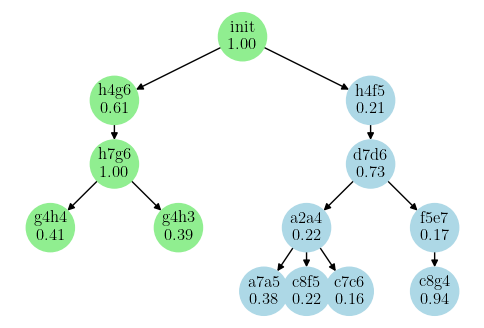

In [22]:
with open("puzzles_double_third.pkl", "rb") as f:
    puzzles = pickle.load(f)
study = DoubleThirdStudy(model, puzzles.iloc[0:1], augment_data=False, save_plots=False, min_prob=[0.1, 0.1, 0.3, 0.05], limit=4)

In [7]:
fen_list = [study.boards[0].fen()]

NameError: name 'study' is not defined

In [5]:
fifth_study = FifthMoveStudy(load_all=False)

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/fifth_move_study.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.effect_sets[tag][possibility] = torch.load(

In [134]:
n_boards = 1024
fen_list = [LeelaBoard.from_puzzle(fifth_study.puzzle_sets['n']['112'].iloc[i]).fen() for i in range(n_boards)]

In [135]:
study = DoubleMateStudy(model, fen_list, augment_data=False, save_plots=False, load_all=False)

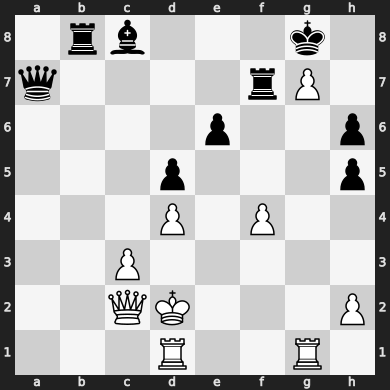

In [82]:
study.boards[0]

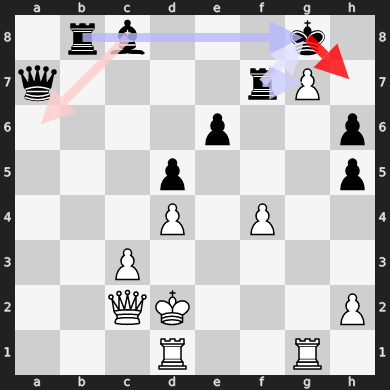

In [146]:
study.get_attributions(layer=11, head=0, topk=5, k=5)
study.attribution_boards[0]

['c2h7', 'g8h7', 'g7g8q']


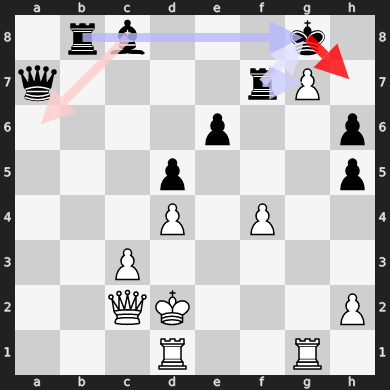

['b7d7', 'd6d7', 'b4c5']


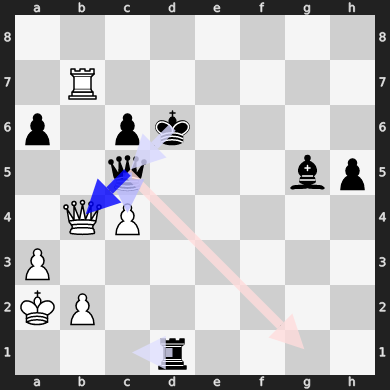

['d6h2', 'g1h2', 'd8d4']


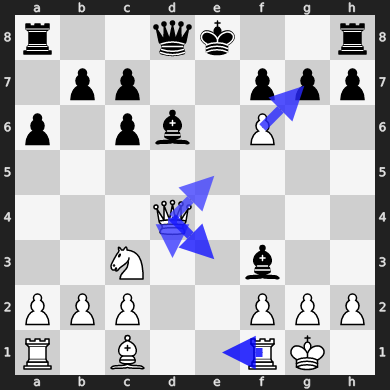

['b3h3', 'g2h3', 'f2h2']


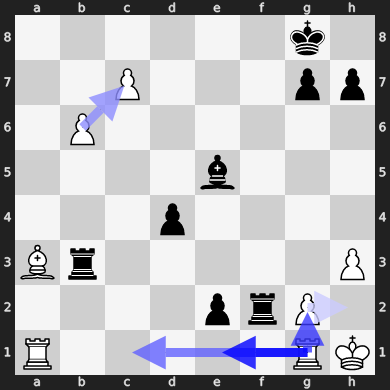

['a1b1', 'c1b1', 'a2a1']


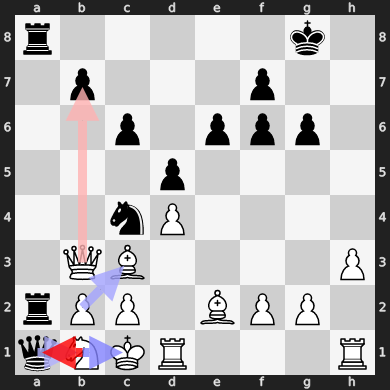

['d6c5', 'd4c5', 'g5g4']


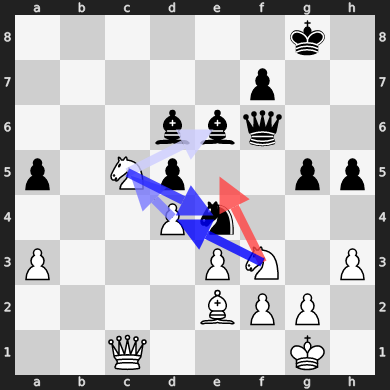

['b3g8', 'f8g8', 'g5f7']


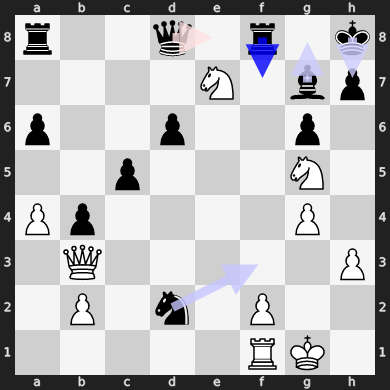

['c8c5', 'b4c5', 'f3f2']


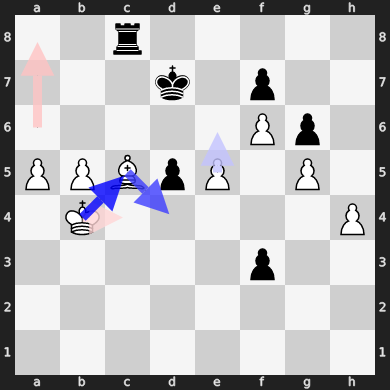

['f7g8', 'f8g8', 'g5f7']


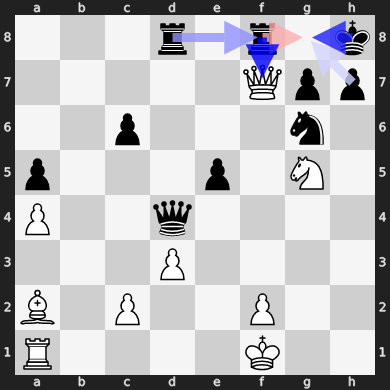

['f8f3', 'g2f3', 'h2f2']


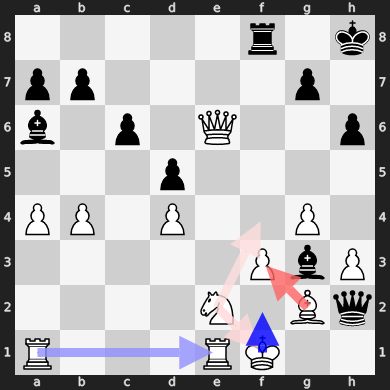

In [148]:
for i in range(10):
    print(fifth_study.puzzle_sets['n']['112'].iloc[i].principal_variation)
    display(study.attribution_boards[i])

In [136]:
value_data = np.zeros((n_boards, 15, 24, 64, 64))

for layer in range(15):
    print(f"Layer: {layer}")
    study.get_attributions_fast(layer=layer, head=slice(0, 24), topk=1, k=4)
    value_data[:, layer, ...] = study.attribution_values

Layer: 0
Layer: 1
Layer: 2
Layer: 3
Layer: 4
Layer: 5
Layer: 6
Layer: 7
Layer: 8
Layer: 9
Layer: 10
Layer: 11
Layer: 12
Layer: 13
Layer: 14


In [137]:
top_squares = [[] for i in range(n_boards)]
top_indices = [[] for i in range(n_boards)]
n_top = 5

for i in range(n_boards):
    max_values = np.max(np.abs(value_data[i]), axis=(0, 1))
    # Get indices of top 10 values in the 64x64 matrix
    top_indices[i] = np.unravel_index(np.argsort(max_values.ravel())[-n_top:], max_values.shape)

    # Convert top_indices to board squares
    board = study.boards[i]  # Assuming we're using the first board in the study

    for idx1, idx2 in zip(top_indices[i][0], top_indices[i][1]):
        from_square = board.idx2sq(idx1)
        to_square = board.idx2sq(idx2)
        top_squares[i].append((from_square, to_square))

    # print("Top 5 square pairs:")
    # for i, (from_sq, to_sq) in enumerate(top_squares, 1):
    #     print(f"{i}. {from_sq}{to_sq}")


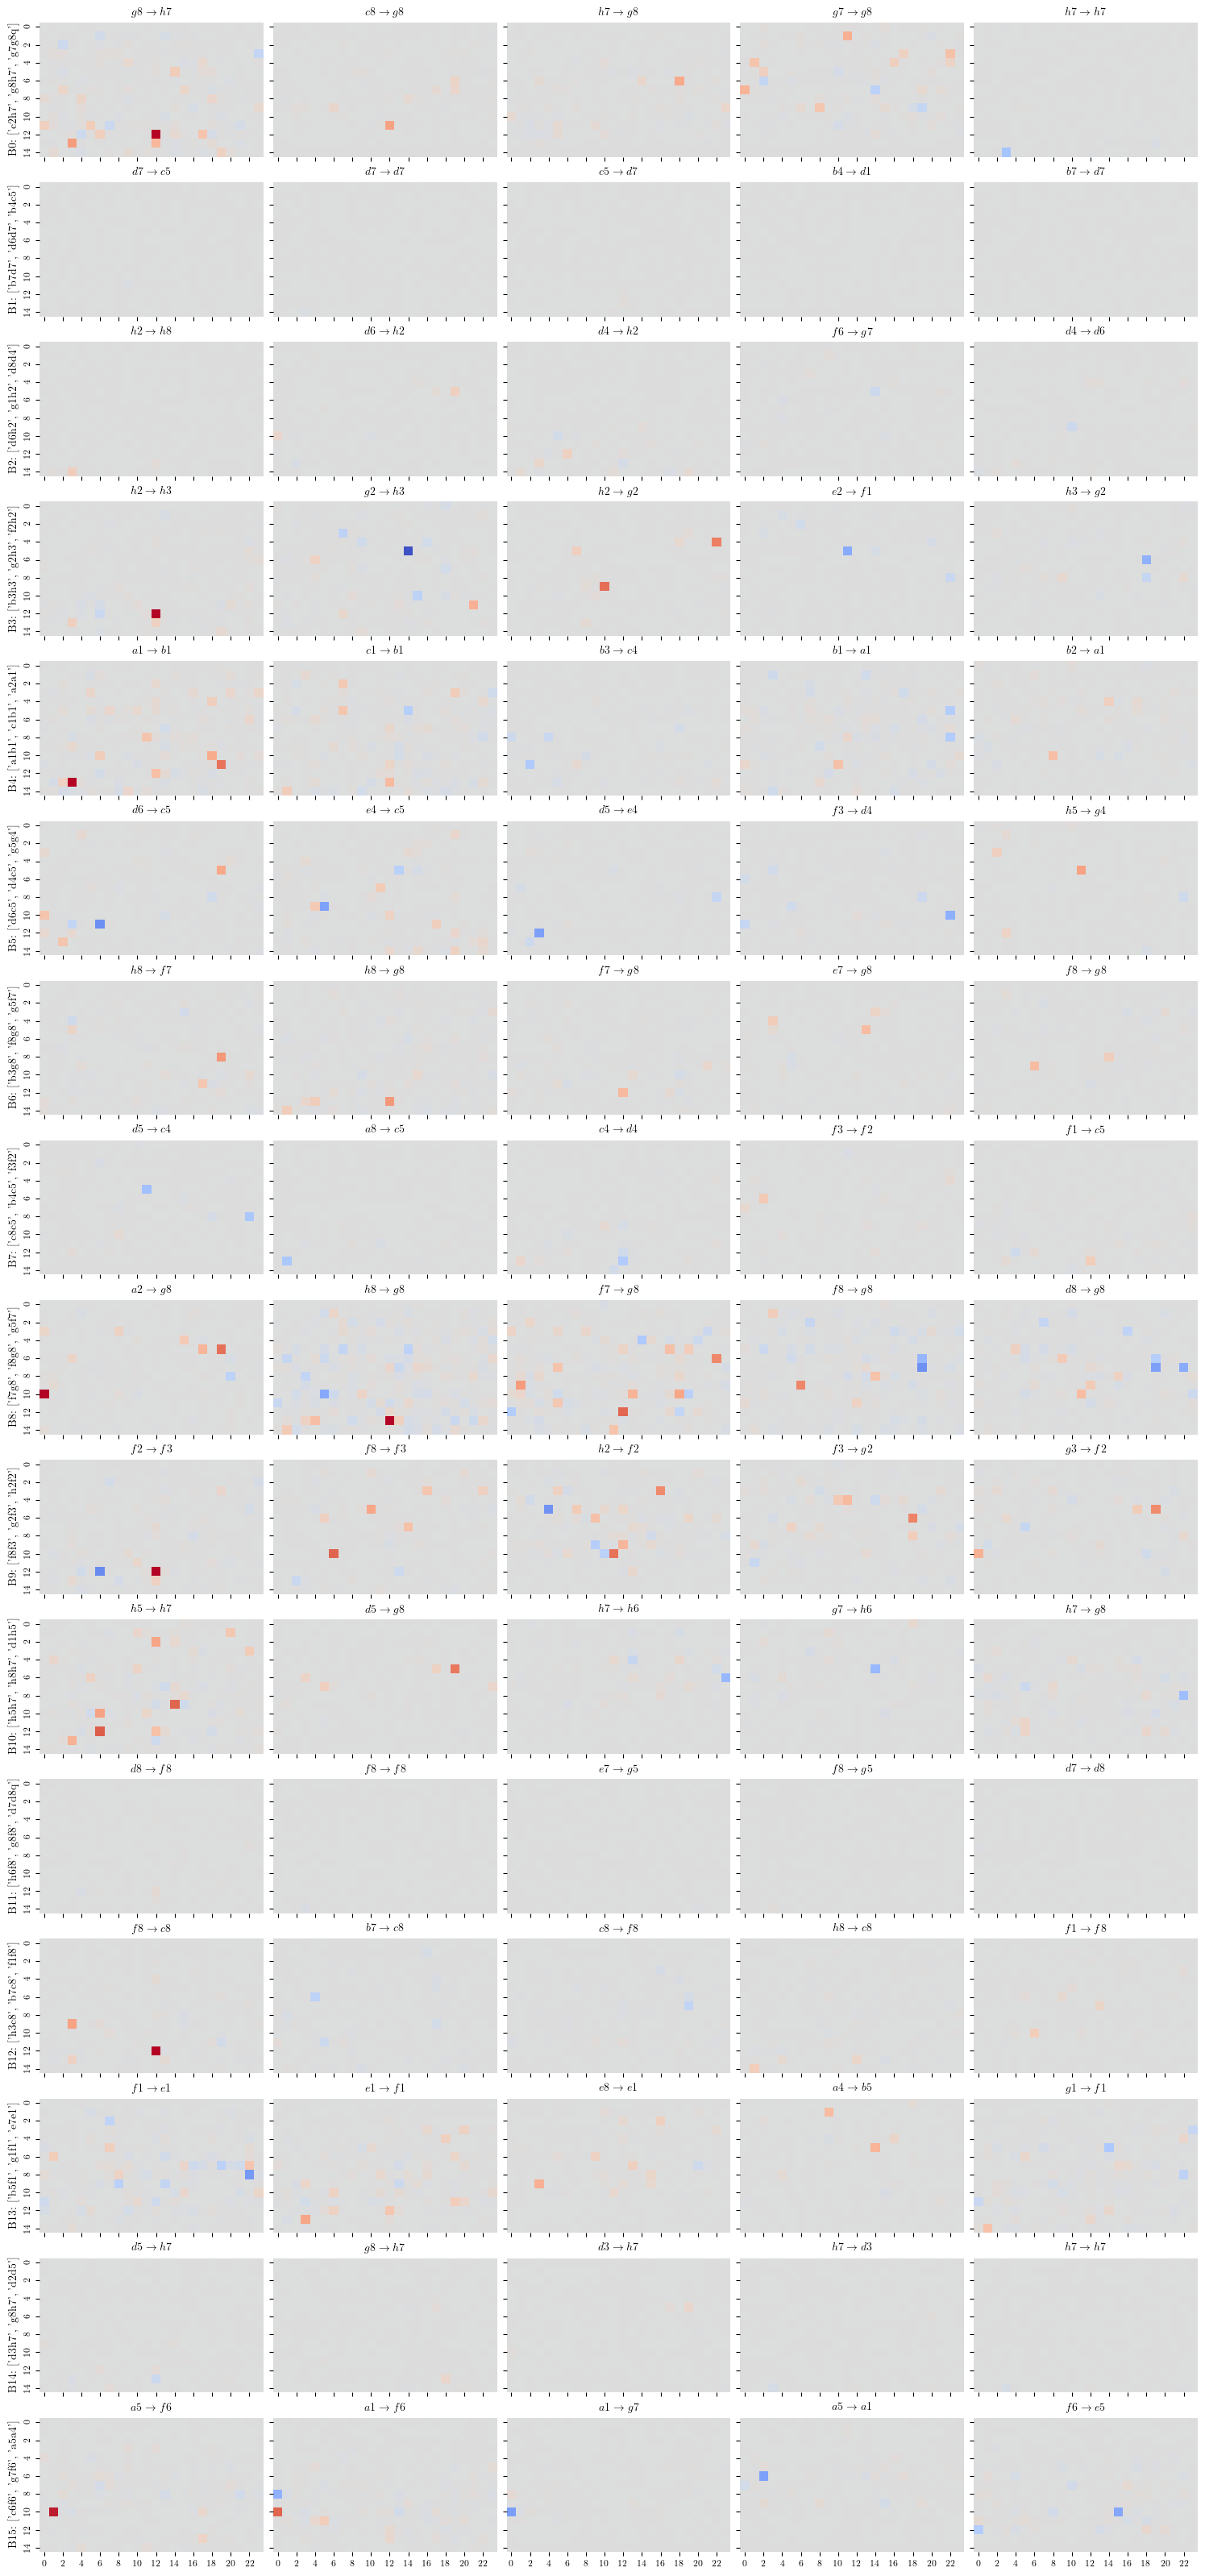

In [107]:
# Plot heatmaps corresponding to the top squares in a grid
fig, axes = plt.subplots(n_boards, n_top, figsize=(3*n_top, 2*n_boards), sharex=True, sharey=True)
#fig.suptitle("Top 10 Square Pairs Heatmaps", fontsize=16)

for i in range(n_boards):
    for j, ((from_sq_idx, to_sq_idx), ax) in enumerate(zip(zip(top_indices[i][0][::-1], top_indices[i][1][::-1]), axes[i].flatten() if n_boards > 1 else axes)):
        sns.heatmap(value_data[i, :, :, from_sq_idx, to_sq_idx], cmap='coolwarm', center=0, ax=ax, cbar=False, vmin=-0.2, vmax=0.2)
        ax.set_title(f"{top_squares[i][n_top-j-1][1]}" + r"$\to$" + f"{top_squares[i][n_top-j-1][0]}")
        ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel(f'B{i}: {fifth_study.puzzle_sets['n']['112'].iloc[i].principal_variation}')

plt.tight_layout()
plt.show()

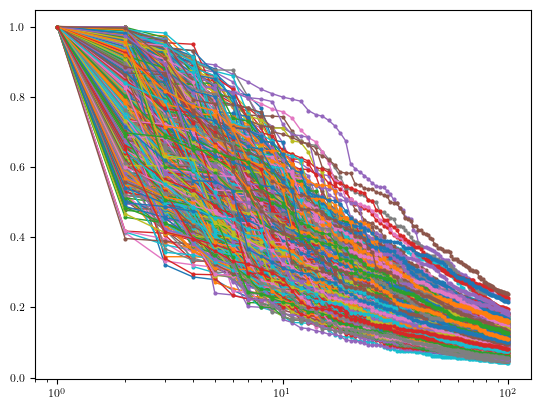

In [138]:
for i in range(n_boards):
    max_values = np.sum(np.abs(value_data[i]), axis=(0, 1)).flatten()
    max_values /= np.max(max_values)
    # Sort in decreasing order
    max_values = np.sort(max_values)[::-1]
    plt.plot(np.arange(1, 100+1), max_values[:100], marker='o', markersize=2, linewidth=1)#, label=f"{i}")
#plt.yscale('log')
plt.xscale('log')
#plt.legend()
plt.show()

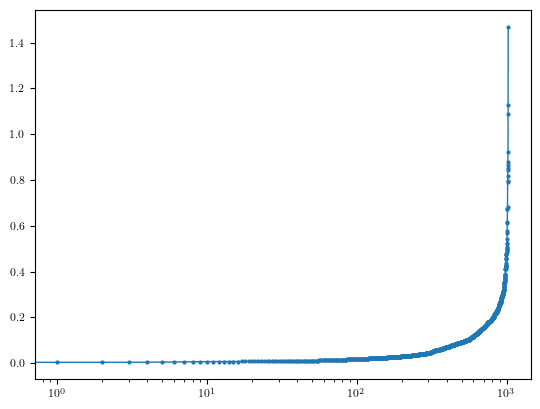

In [144]:
max_list = []
for i in range(n_boards):
    max_values = np.max(np.abs(value_data[i]), axis=(0, 1)).flatten() # Might change to sum
    max_value = np.max(max_values)
    max_list.append(max_value)
max_sorted_list = np.sort(max_list)[::-1]
max_indices = np.argsort(max_list)[::-1][:10]
plt.plot(max_sorted_list, marker='o', markersize=2, linewidth=1)
#plt.yscale('log')
plt.xscale('log')
plt.show()

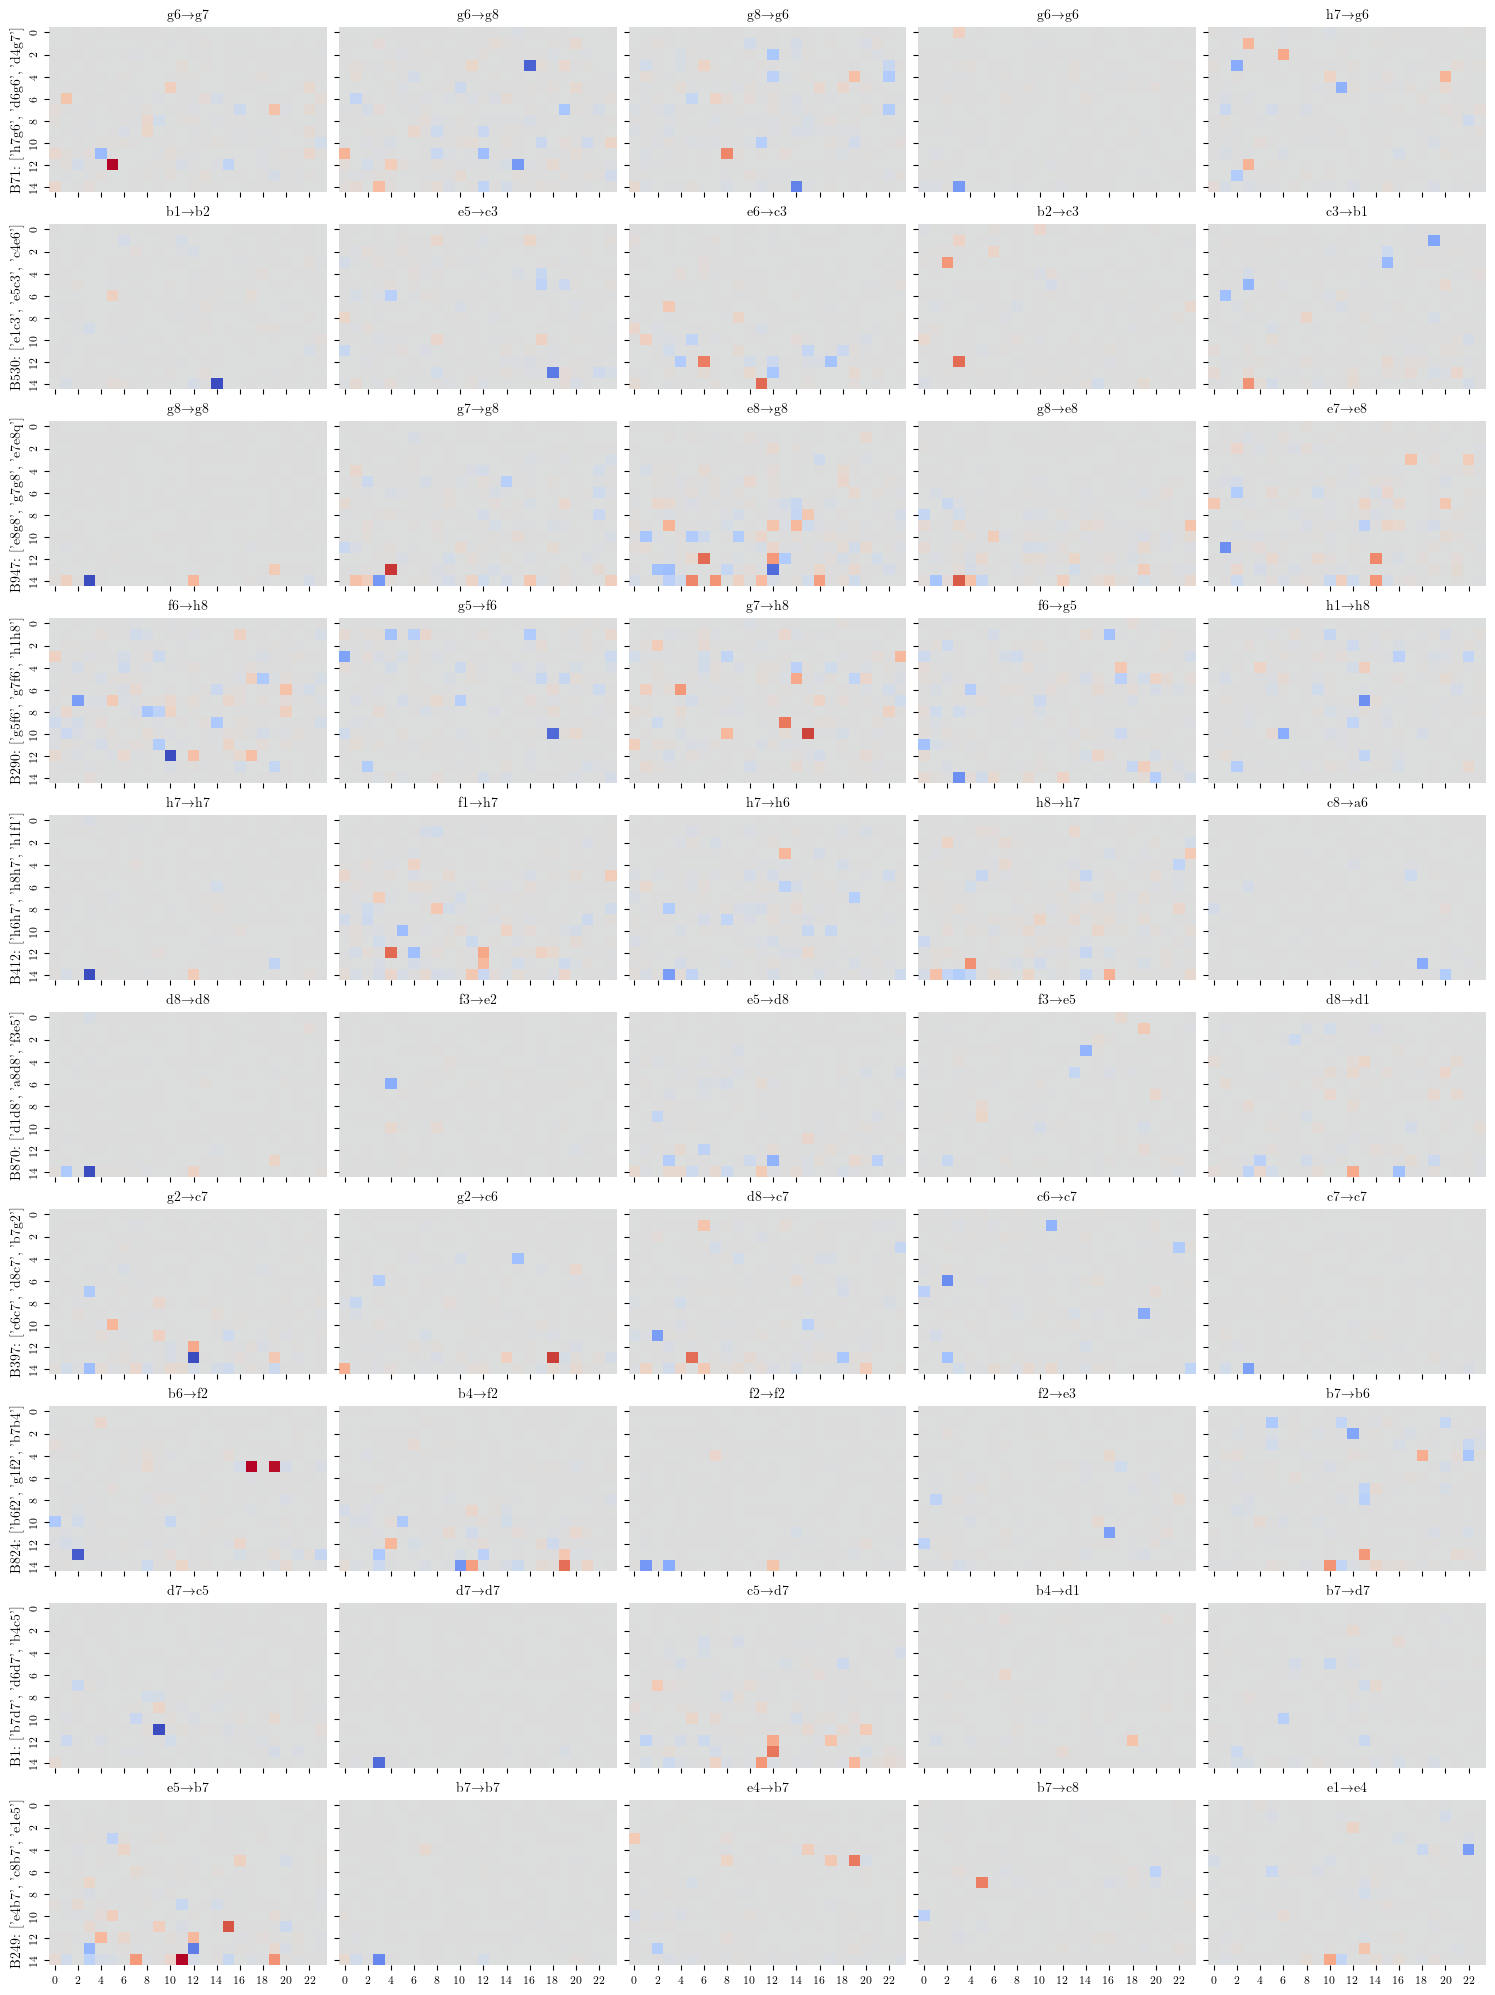

In [145]:
# Plot heatmaps corresponding to the top squares in a grid
fig, axes = plt.subplots(len(max_indices), n_top, figsize=(3*n_top, 2*len(max_indices)), sharex=True, sharey=True)
#fig.suptitle("Top 10 Square Pairs Heatmaps", fontsize=16)

for k, i in enumerate(max_indices):
    for j, ((from_sq_idx, to_sq_idx), ax) in enumerate(zip(zip(top_indices[i][0][::-1], top_indices[i][1][::-1]), axes[k].flatten() if n_boards > 1 else axes)):
        sns.heatmap(value_data[i, :, :, from_sq_idx, to_sq_idx], cmap='coolwarm', center=0, ax=ax, cbar=False, vmin=-max_sorted_list[k], vmax=max_sorted_list[k])
        ax.set_title(f"{top_squares[i][n_top-j-1][1]}" + r"$\to$" + f"{top_squares[i][n_top-j-1][0]}")
        ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel(f'B{i}: {fifth_study.puzzle_sets['n']['112'].iloc[i].principal_variation}')

plt.tight_layout()
plt.show()

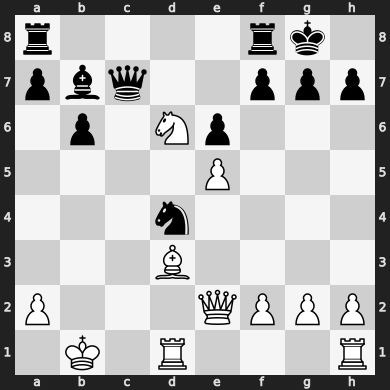

In [133]:
study.boards[57]

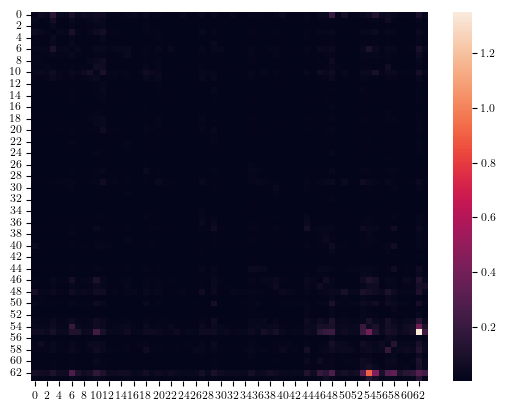

In [89]:
max_values = np.sum(np.abs(value_data[0]), axis=(0, 1))
sns.heatmap(max_values)
plt.show()

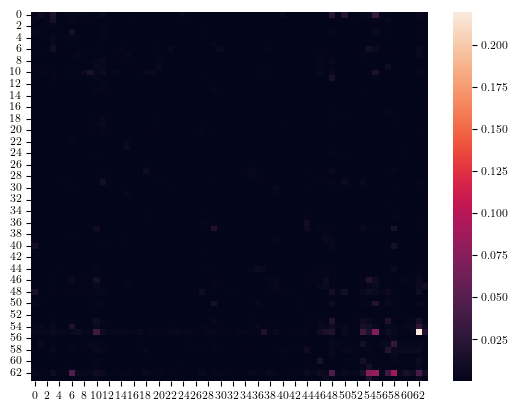

In [68]:
max_values = np.max(np.abs(value_data[0]), axis=(0, 1))
sns.heatmap(max_values)
plt.show()

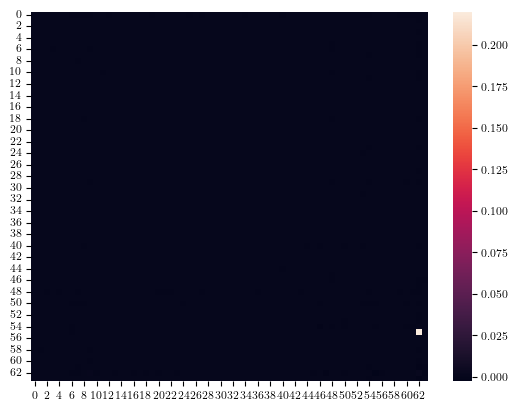

In [58]:
sns.heatmap(value_data[12, 12])
plt.show()

In [57]:
sns.heatmap(value_data.T)
plt.show()

ValueError: Must pass 2-d input. shape=(64, 64, 24, 15)

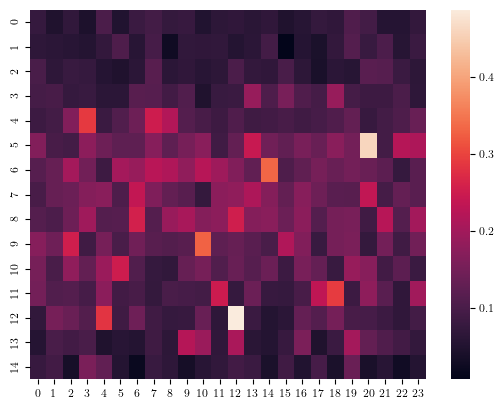

In [26]:
# Seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

fh.set()
sns.heatmap(value_data)
plt.show()

In [23]:
study.attribution_values[0]

{'c8f7': 0.16623267531394958,
 'g8f7': 0.12109224498271942,
 'c8d7': -0.06656290590763092,
 'g8d7': -0.043143242597579956,
 'f7g5': -0.006342764012515545,
 'd7c5': -0.004008593037724495,
 'f7c5': -0.003667982993647456,
 'd7g5': -0.0027141377795487642,
 'f7g8': 0.0025932500138878822,
 'd7g8': 0.001528506982140243,
 'a1e6': -0.001083176932297647,
 'a1g5': -0.0009077722788788378,
 'h1g1': -0.0008346542599610984,
 'a1f8': 0.0007399367750622332,
 'a1f7': 0.0007267671753652394,
 'c8h7': -0.0006430585053749382,
 'c8b3': -0.000624075357336551,
 'a1d8': 0.0006105200736783445,
 'f8e8': 0.0005887367879040539,
 'e8f7': 0.0005622267490252852,
 'f7c8': 0.0005492052878253162,
 'g8h7': -0.0005018908414058387,
 'e8d8': 0.000460151641163975,
 'f7c1': -0.0004382140759844333,
 'f8d8': 0.0004246669413987547,
 'f6d6': -0.00040196083136834204,
 'g8a5': -0.00038541966932825744,
 'g8e6': -0.0003794041695073247,
 'g8e8': 0.00036409287713468075,
 'f7d8': 0.0003589511616155505,
 'c7f7': 0.00035437560291029513,
 '

In [102]:
from leela_interp.core.effect_study import *

In [105]:
study = EffectStudy(model, puzzlename="all", n_examples=200)

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.all_effects = -torch.load(
/home/dcruz/Pivotal

In [110]:
diff_puzzles = study.puzzles.copy()
print(f"Puzzles: {study.puzzles.shape[0]}")

diff_puzzles = diff_puzzles[diff_puzzles["principal_variation"].apply(lambda x: len(x)) == 3]
print(f"Puzzles with 3 moves in principal variation: {diff_puzzles.shape[0]}")

diff_puzzles = diff_puzzles[diff_puzzles["Themes"].apply(lambda x: "mateIn2" in x)]
print(f"Puzzles that are mate in 2: {diff_puzzles.shape[0]}")

diff_puzzles = diff_puzzles[diff_puzzles["full_pv_probs"].apply(lambda x: x[1] > 0.9)]
print(f"Puzzles with second move probability > 0.9: {diff_puzzles.shape[0]}")

diff_puzzles = diff_puzzles[diff_puzzles["full_pv_probs"].apply(lambda x: x[0] > 0.5)]
print(f"Puzzles with first move probability > 0.5: {diff_puzzles.shape[0]}")

diff_puzzles = diff_puzzles[diff_puzzles.principal_variation.apply(lambda x: x[0][2:4] == x[1][2:4])]
print(f"Puzzles with same start and middle squares in principal variation: {diff_puzzles.shape[0]}")

diff_puzzles = diff_puzzles[diff_puzzles.principal_variation.apply(lambda x: x[0][2:4] != x[2][2:4])]
print(f"Puzzles with different start and end squares in principal variation: {diff_puzzles.shape[0]}")

diff_puzzles = diff_puzzles[diff_puzzles["full_pv_probs"].apply(lambda x: x[2] < 0.5)]
print(f"Puzzles with third move probability < 0.5: {diff_puzzles.shape[0]}")

Puzzles: 52498
Puzzles with 3 moves in principal variation: 32076
Puzzles that are mate in 2: 5387
Puzzles with second move probability > 0.9: 4460
Puzzles with first move probability > 0.5: 3892
Puzzles with same start and middle squares in principal variation: 1373
Puzzles with different start and end squares in principal variation: 435
Puzzles with third move probability < 0.5: 10


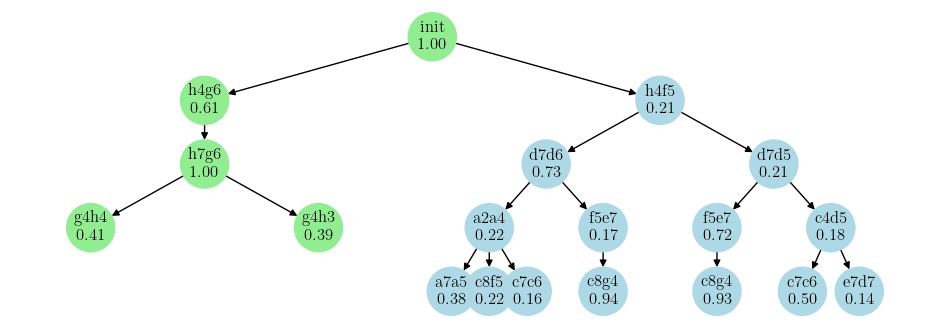

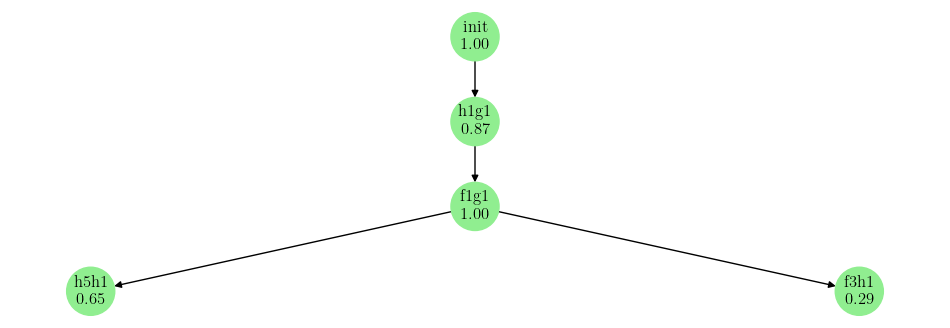

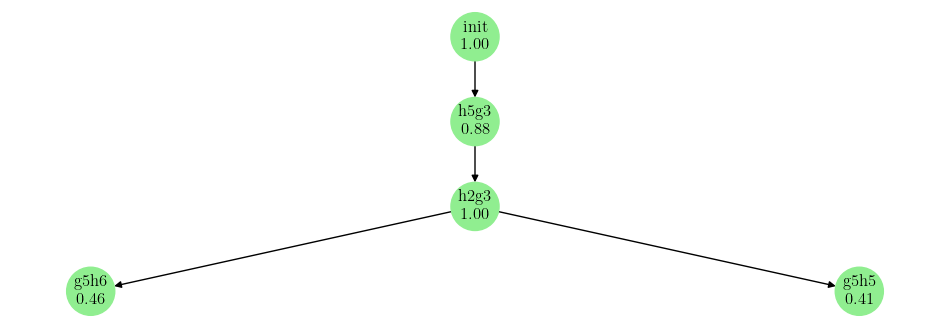

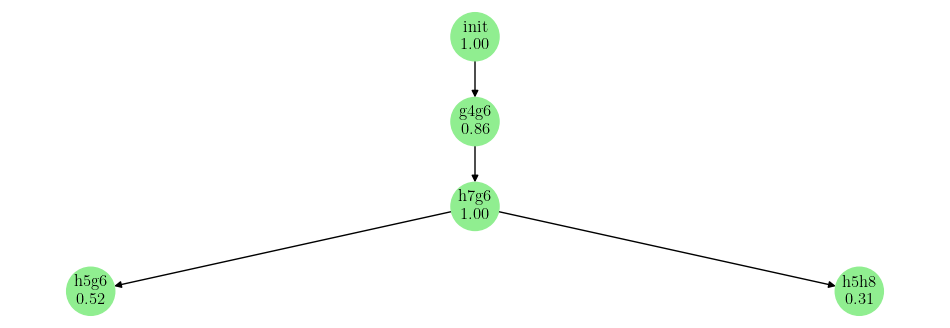

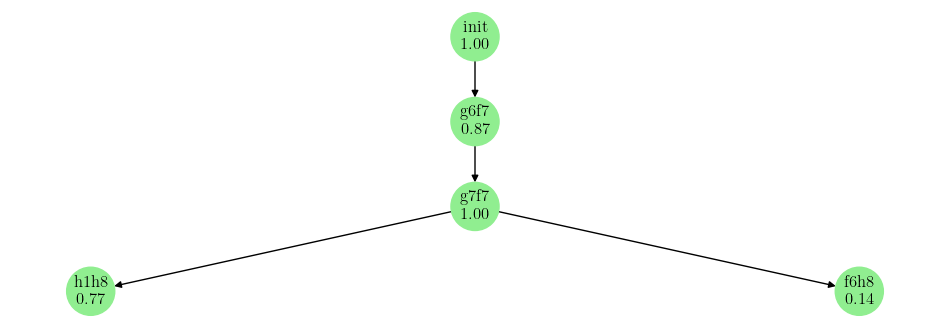

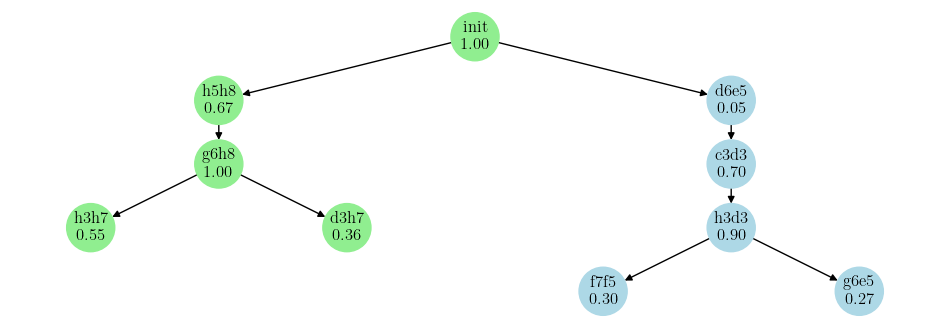

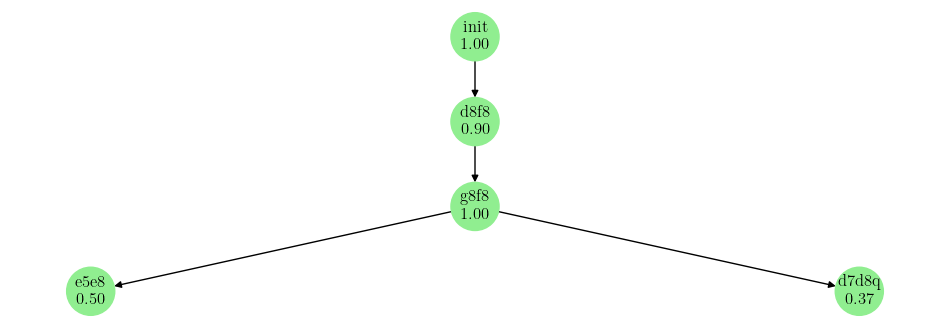

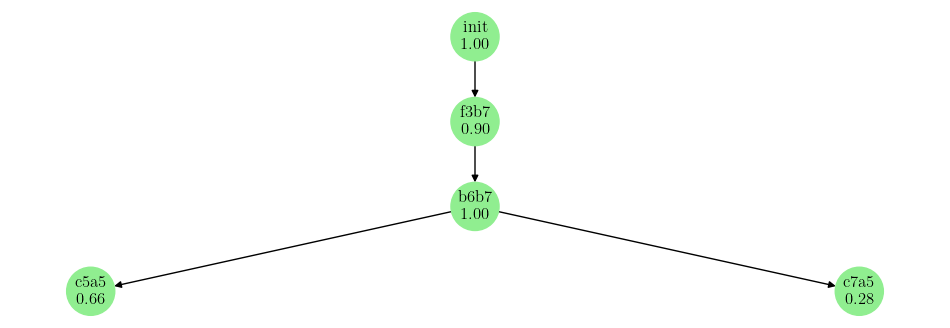

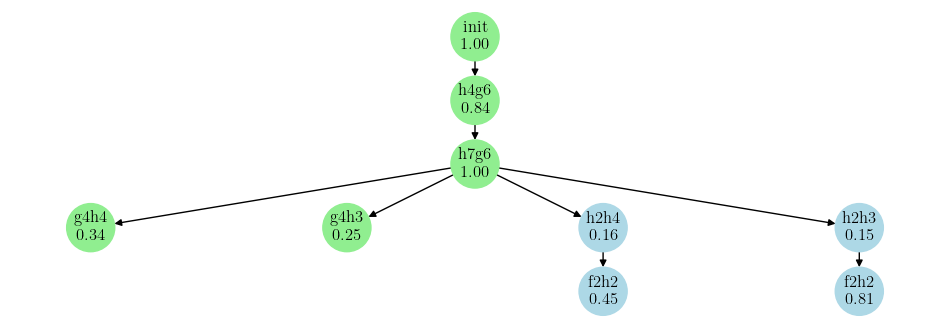

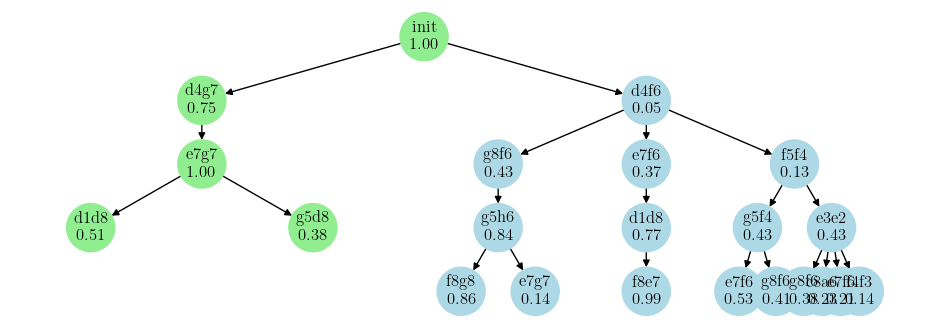

In [112]:
min_prob = [0.1, 0.1, 0.1, 0.05]
boards = [LeelaBoard.from_puzzle(x) for _, x in diff_puzzles.iterrows()]
for board in boards:
    moveset = get_top_moves(model, board, limit=4, min_prob=min_prob)
    total_moveset = {'init': {'prob': 1.0} | moveset}
    DoubleMateStudy.tree_figure(total_moveset)

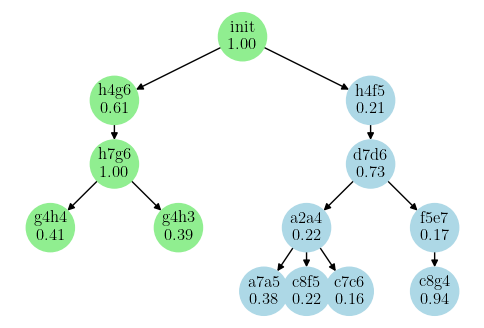

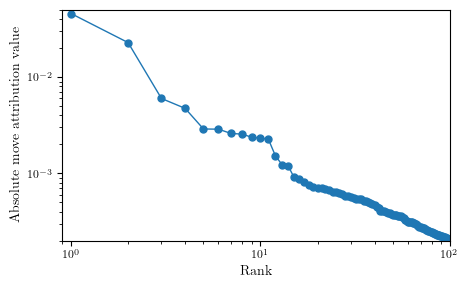

In [155]:
with open("puzzles_double_third.pkl", "rb") as f:
    puzzles = pickle.load(f)
study = DoubleThirdStudy(model, puzzles.iloc[0:1], augment_data=False, save_plots=True, min_prob=[0.1, 0.1, 0.3, 0.05], limit=4)

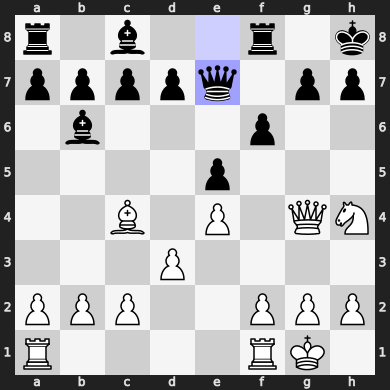

In [150]:
study.boards[0]

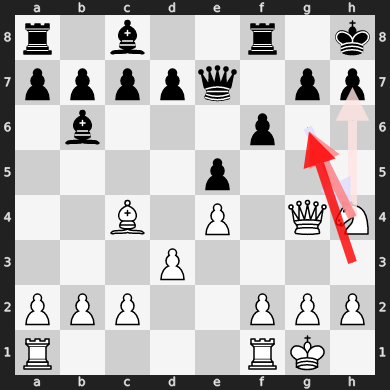

In [151]:
study.attribution_boards[0]

In [152]:
study.attribution_values[0]

{'h3g6': 0.04583367705345154,
 'h4g6': 0.0228712297976017,
 'g6h4': -0.006001126952469349,
 'h4h7': 0.004736660048365593,
 'g6h8': -0.002890715841203928,
 'e7h8': -0.0028768095653504133,
 'g6h7': -0.0025943962391465902,
 'h3h7': 0.002556821098551154,
 'e8g7': -0.002369654132053256,
 'h8g6': 0.002318812068551779,
 'g6h3': -0.002269693184643984,
 'h8h7': 0.0015144480857998133,
 'h4h8': -0.0012301235692575574,
 'e7f5': -0.0011918103555217385,
 'g6h6': 0.0009160498739220202,
 'e7c4': -0.0008798857452347875,
 'e7g8': 0.0008072817581705749,
 'g6e7': -0.0007572889444418252,
 'h6h4': -0.0007202363340184093,
 'g8g6': 0.0007029263069853187,
 'h4e7': -0.0006951690302230418,
 'g6g8': 0.000683818303514272,
 'e7h6': -0.0006690557347610593,
 'd5f5': -0.0006443549646064639,
 'e7h5': -0.0006410967325791717,
 'e8f5': 0.0006290339515544474,
 'h4g7': -0.0006046933704055846,
 'g6h5': -0.0005766671965830028,
 'f7h7': 0.0005760447820648551,
 'g6g4': -0.000570347998291254,
 'g6g7': -0.0005556053365580738,
 'e

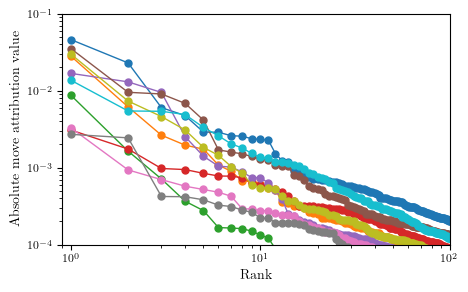

In [148]:
fig, ax = plt.subplots(figsize=(5, 3))
for i, values in enumerate(study.attribution_values):
    # Plot the data
    x = np.arange(1, len(values)+1)
    y = np.abs(list(values.values()))
    ax.plot(x, y, marker='o', linestyle='-', markersize=5, linewidth=1)

    # Set scales and labels
    ax.set_xscale('log')
    ax.set_xlim(0.9, 100)
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1e-1)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Absolute move attribution value')
plt.show()